In [1]:
import requests
import pandas as pd
import scipy.spatial.distance as ssd

In [2]:
def query(postcode, offset=0):
    """Query  Ordnance Survey postcode places API:
    https://apidocs.os.uk/docs/os-places-postcode"""
    URL = 'https://api.ordnancesurvey.co.uk/places/v1/addresses/postcode'
    params = {'postcode': postcode,
              'key': 'dxp6QRGemG64Aj4HdswNnIAzjIyKwMt1',
              'offset': offset}
    data = requests.get(URL, params=params).json()
    header = data['header']
    results = data['results']
    yield [d['DPA'] for d in results]
    if header['totalresults'] > offset + header['maxresults']:
        yield from query(postcode, offset=offset + header['maxresults'])

In [4]:
directory = input()
datapath= 'PTAL_Grid_2018_2021_2031.csv'
ptal_data = pd.read_csv(directory + datapath)

ptal_data = ptal_data.rename(columns= {'PTALBY': 'PTAL_2018'})
points = ptal_data[['X', 'Y']].values

/Users/vincentmargerin/CityDataHack/data/


In [5]:
def get_data(postcode):
    "Get data from OS places API as DataFrame joined with TfL PTAL data"
    df = pd.concat(pd.DataFrame(res) for res in query(postcode))
    df = df.rename(columns={'X_COORDINATE': 'X', 'Y_COORDINATE': 'Y'})
    df['PTAL_2018'] = df.apply(lambda r: ptal_data.PTAL_2018[ssd.cdist([[r['X'], r['Y']]],
                                                                       points).argmin()],
                               axis=1)
    return df

In [6]:
postcode = 'N5'
df = get_data(postcode)
df['Region'] = postcode

In [7]:
# Turn PTAL into a numeric column
df = df.replace(to_replace={'PTAL_2018': {'6a': '6', '6b': '7'}})
df['PTAL_2018'] = pd.to_numeric(df['PTAL_2018'])
df.describe()

,LOCAL_CUSTODIAN_CODE,MATCH,X,Y,PTAL_2018
count,10023.000000,10023.0,10023.000000,10023.000000,10023.000000
mean,5576.343909,1.0,531925.823106,185673.366936,4.701387
std,141.820190,0.0,380.010377,403.899651,1.293076
min,5360.000000,1.0,531183.000000,184748.000000,2.000000
25%,5570.000000,1.0,531600.000000,185316.000000,4.000000
50%,5570.000000,1.0,531918.000000,185701.000000,5.000000
75%,5570.000000,1.0,532225.000000,185996.000000,6.000000
max,7655.000000,1.0,532773.000000,186495.000000,7.000000


In [8]:
df.CLASSIFICATION_CODE_DESCRIPTION.value_counts()

Dwelling                                                           4748
Self Contained Flat (Includes Maisonette / Apartment)              3405
Property Shell                                                     1250
Terraced                                                            203
Shop / Showroom                                                     132
Dual Use                                                             47
Commercial                                                           40
Retail                                                               31
PO Box                                                               28
Office / Work Studio                                                 24
Detached                                                             17
Additional Mail / Packet Addressee                                   17
Semi-Detached                                                        11
Residential                                                     

In [9]:
datapath2= 'CO2_dataframe.csv'
co2_df = pd.read_csv(directory + datapath2, thousands=',')
co2_df = co2_df.rename(columns= {'Total': 'Total_CO2',
                                 'Easting': 'X',
                                 'Northing': 'Y'})
co2_df.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,X,Y,Borough,Zone,Total_CO2
0,2008,5910,1,510500,203500,NonGLA,NonGLA,886.07
1,2008,5911,2,511500,203500,NonGLA,NonGLA,13999.04
2,2008,5912,3,512500,203500,NonGLA,NonGLA,7950.19
3,2008,5915,4,515500,203500,NonGLA,NonGLA,11873.98
4,2008,5916,5,516500,203500,NonGLA,NonGLA,5534.79


In [10]:
co2_points = co2_df[['X', 'Y']].values
df['Total_CO2'] = df.apply(lambda row: co2_df.Total_CO2[ssd.cdist([[row['X'], row['Y']]],
                                                                  co2_points).argmin()],
                           axis=1)
df.head()

,ADDRESS,BLPU_STATE_CODE,BLPU_STATE_CODE_DESCRIPTION,BLPU_STATE_DATE,BUILDING_NAME,BUILDING_NUMBER,CLASSIFICATION_CODE,CLASSIFICATION_CODE_DESCRIPTION,DEPARTMENT_NAME,DEPENDENT_THOROUGHFARE_NAME,...,SUB_BUILDING_NAME,THOROUGHFARE_NAME,TOPOGRAPHY_LAYER_TOID,UDPRN,UPRN,X,Y,PTAL_2018,Region,Total_CO2
0,"FLAT 9, MATTHEWS COURT, HIGHBURY GRANGE, LONDO...",NaN,Unknown/Not applicable,NaN,MATTHEWS COURT,NaN,RD,Dwelling,NaN,NaN,...,FLAT 9,HIGHBURY GRANGE,osgb1000005904328,15522705,5300043373,532011.0,185698.0,2,N5,19493.78
1,"FLAT 21, DRAKELEY COURT, AUBERT PARK, LONDON, ...",NaN,Unknown/Not applicable,NaN,DRAKELEY COURT,NaN,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,NaN,...,FLAT 21,AUBERT PARK,osgb1000005746331,15519501,5300044167,531608.0,185825.0,5,N5,24800.88
2,"54, PARK VIEW, COLLINS ROAD, LONDON, N5 2UD",NaN,Unknown/Not applicable,NaN,NaN,54,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,PARK VIEW,...,NaN,COLLINS ROAD,osgb1000005904063,15524288,5300022720,532408.0,185842.0,3,N5,19493.78
3,"FLAT 11, 71A, DRAYTON PARK, LONDON, N5 1AN",NaN,Unknown/Not applicable,NaN,71A,NaN,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,NaN,...,FLAT 11,DRAYTON PARK,osgb1000001802755910,50611428,10012793706,531447.0,185570.0,6,N5,24800.88
4,"141, PARK VIEW, COLLINS ROAD, LONDON, N5 2UE",NaN,Unknown/Not applicable,NaN,NaN,141,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,PARK VIEW,...,NaN,COLLINS ROAD,osgb1000005904047,15524363,5300022795,532365.0,185905.0,2,N5,19493.78


In [11]:
scores = df[['PTAL_2018', 'Total_CO2']]
ptal_co2 = pd.DataFrame.corr(scores)
ptal_co2

,PTAL_2018,Total_CO2
PTAL_2018,1.000000,0.256944
Total_CO2,0.256944,1.000000


In [12]:
df.describe()

,LOCAL_CUSTODIAN_CODE,MATCH,X,Y,PTAL_2018,Total_CO2
count,10023.000000,10023.0,10023.000000,10023.000000,10023.000000,10023.000000
mean,5576.343909,1.0,531925.823106,185673.366936,4.701387,18647.472693
std,141.820190,0.0,380.010377,403.899651,1.293076,7683.895139
min,5360.000000,1.0,531183.000000,184748.000000,2.000000,4630.100000
25%,5570.000000,1.0,531600.000000,185316.000000,4.000000,19493.780000
50%,5570.000000,1.0,531918.000000,185701.000000,5.000000,19493.780000
75%,5570.000000,1.0,532225.000000,185996.000000,6.000000,24800.880000
max,7655.000000,1.0,532773.000000,186495.000000,7.000000,29136.180000


In [13]:
datapath3= 'ssx_openmapping_gb_v1.csv'
syntax_data = pd.read_csv(directory + datapath3)
syntax_data.head()

,id,metres,meridian_id,meridian_gid,meridian_code,meridian_osodr,meridian_number,meridian_road_name,meridian_indicator,meridian_class,...,oa11cd,wz11cd,lsoa11cd,lsoa11nm,msoa11cd,msoa11nm,lad11cd,lad11nm,meridian_class_scale,wkt
0,5470,59.908263,761424,756472,3004,O16BHGHF0PPAW,NaN,STENTIFORD HILL ROAD,NaN,minor,...,E00076895,E33048014,E01015217,Torbay 008A,E02003161,Torbay 008,E06000027,Torbay,1,"LINESTRING(291820 63959,291805 64017)"
1,5471,99.126182,761424,756472,3004,O16BHGHF0PPAW,NaN,STENTIFORD HILL ROAD,NaN,minor,...,E00076895,E33048014,E01015217,Torbay 008A,E02003161,Torbay 008,E06000027,Torbay,1,"LINESTRING(291805 64017,291706 64022)"
2,5472,199.123078,761425,756473,3004,O16BGENY0X2AW,NaN,WHIDBORNE AVENUE,NaN,minor,...,E00077168,E33048019,E01015271,Torbay 010E,E02003163,Torbay 010,E06000027,Torbay,1,"LINESTRING(294362 63533,294207 63658)"
3,5473,241.615397,761425,756473,3004,O16BGENY0X2AW,NaN,WHIDBORNE AVENUE,NaN,minor,...,E00077168,E33048019,E01015271,Torbay 010E,E02003163,Torbay 010,E06000027,Torbay,1,"LINESTRING(294207 63658,293970 63611)"
4,5474,149.201206,761425,756473,3004,O16BGENY0X2AW,NaN,WHIDBORNE AVENUE,NaN,minor,...,E00077168,E33048019,E01015271,Torbay 010E,E02003163,Torbay 010,E06000027,Torbay,1,"LINESTRING(293970 63611,293851 63521)"


In [15]:
syntax_rank_data = syntax_data[['lsoa11cd',
                                'choice2kmrank',
                                'choice10kmrank',
                                'integration2kmrank',
                                'integration10kmrank']].groupby('lsoa11cd').first()
syntax_rank_data.head()

,choice2kmrank,choice10kmrank,integration2kmrank,integration10kmrank
lsoa11cd,,,,
E01000001,0.702755,0.653590,0.773448,0.868787
E01000002,0.120910,0.186543,0.417083,0.779824
E01000003,0.702438,0.678286,0.856823,0.893001
E01000005,0.781888,0.977377,0.781888,0.966803
E01000006,0.627383,0.649739,0.507221,0.388833


In [16]:
datapath4 = 'd4278d47b8db3858f75e76803de4ce697.csv'
geo_data = pd.read_csv(directory + datapath4)
geo_data = geo_data.rename(columns= {'LSOA Code': 'lsoa11cd',
                                     'Easting': 'X',
                                     'Northing': 'Y'})
geo_data_thin = geo_data[['lsoa11cd', 'X', 'Y']].groupby('lsoa11cd').first()
geo_data_thin.head()

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (17,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,X,Y
lsoa11cd,,
E01000001,532162,181306
E01000002,532601,181925
E01000003,532094,182111
E01000005,533623,181382
E01000006,544804,184253


In [17]:
choice_integration_data = syntax_rank_data.merge(geo_data_thin,
                                                 left_index=True,
                                                 right_index=True).reset_index()
choice_integration_data.head()

,lsoa11cd,choice2kmrank,choice10kmrank,integration2kmrank,integration10kmrank,X,Y
0,E01000001,0.702755,0.653590,0.773448,0.868787,532162,181306
1,E01000002,0.120910,0.186543,0.417083,0.779824,532601,181925
2,E01000003,0.702438,0.678286,0.856823,0.893001,532094,182111
3,E01000005,0.781888,0.977377,0.781888,0.966803,533623,181382
4,E01000006,0.627383,0.649739,0.507221,0.388833,544804,184253


In [18]:
chint_points = choice_integration_data[['X', 'Y']].values
for c in ['choice2kmrank', 'choice10kmrank', 'integration2kmrank', 'integration10kmrank']:
    df[c] = df.apply(lambda r: choice_integration_data[c][ssd.cdist([[r['X'], r['Y']]],
                                                                    chint_points).argmin()],
                     axis=1)
df.head()

,ADDRESS,BLPU_STATE_CODE,BLPU_STATE_CODE_DESCRIPTION,BLPU_STATE_DATE,BUILDING_NAME,BUILDING_NUMBER,CLASSIFICATION_CODE,CLASSIFICATION_CODE_DESCRIPTION,DEPARTMENT_NAME,DEPENDENT_THOROUGHFARE_NAME,...,UPRN,X,Y,PTAL_2018,Region,Total_CO2,choice2kmrank,choice10kmrank,integration2kmrank,integration10kmrank
0,"FLAT 9, MATTHEWS COURT, HIGHBURY GRANGE, LONDO...",NaN,Unknown/Not applicable,NaN,MATTHEWS COURT,NaN,RD,Dwelling,NaN,NaN,...,5300043373,532011.0,185698.0,2,N5,19493.78,0.391635,0.150662,0.075201,0.485135
1,"FLAT 21, DRAKELEY COURT, AUBERT PARK, LONDON, ...",NaN,Unknown/Not applicable,NaN,DRAKELEY COURT,NaN,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,NaN,...,5300044167,531608.0,185825.0,5,N5,24800.88,0.633233,0.632601,0.098149,0.605153
2,"54, PARK VIEW, COLLINS ROAD, LONDON, N5 2UD",NaN,Unknown/Not applicable,NaN,NaN,54,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,PARK VIEW,...,5300022720,532408.0,185842.0,3,N5,19493.78,0.937332,0.921780,0.709937,0.811972
3,"FLAT 11, 71A, DRAYTON PARK, LONDON, N5 1AN",NaN,Unknown/Not applicable,NaN,71A,NaN,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,NaN,...,10012793706,531447.0,185570.0,6,N5,24800.88,0.706764,0.839579,0.678938,0.819874
4,"141, PARK VIEW, COLLINS ROAD, LONDON, N5 2UE",NaN,Unknown/Not applicable,NaN,NaN,141,RD06,Self Contained Flat (Includes Maisonette / Apa...,NaN,PARK VIEW,...,5300022795,532365.0,185905.0,2,N5,19493.78,0.937332,0.921780,0.709937,0.811972


In [19]:
scores = df[['PTAL_2018', 'Total_CO2', 'choice2kmrank', 'choice10kmrank',
             'integration2kmrank', 'integration10kmrank']]
all_n5_scores = pd.DataFrame.corr(scores)
all_n5_scores

,PTAL_2018,Total_CO2,choice2kmrank,choice10kmrank,integration2kmrank,integration10kmrank
PTAL_2018,1.000000,0.256944,-0.088981,0.058152,0.122987,0.177760
Total_CO2,0.256944,1.000000,0.163518,0.135813,0.154652,0.114479
choice2kmrank,-0.088981,0.163518,1.000000,0.933669,0.838229,0.816303
choice10kmrank,0.058152,0.135813,0.933669,1.000000,0.883855,0.917607
integration2kmrank,0.122987,0.154652,0.838229,0.883855,1.000000,0.953616
integration10kmrank,0.177760,0.114479,0.816303,0.917607,0.953616,1.000000


In [21]:
scores = scores.rename(columns= {'choice2kmrank': 'choice_2km',
                                 'choice10kmrank': 'choice_10km',
                                 'integration2kmrank': 'int_2km',
                                 'integration10kmrank': 'int_10km'})
all_n5_scores = pd.DataFrame.corr(scores)
all_n5_scores

,PTAL_2018,Total_CO2,choice_2km,choice_10km,int_2km,int_10km
PTAL_2018,1.000000,0.256944,-0.088981,0.058152,0.122987,0.177760
Total_CO2,0.256944,1.000000,0.163518,0.135813,0.154652,0.114479
choice_2km,-0.088981,0.163518,1.000000,0.933669,0.838229,0.816303
choice_10km,0.058152,0.135813,0.933669,1.000000,0.883855,0.917607
int_2km,0.122987,0.154652,0.838229,0.883855,1.000000,0.953616
int_10km,0.177760,0.114479,0.816303,0.917607,0.953616,1.000000


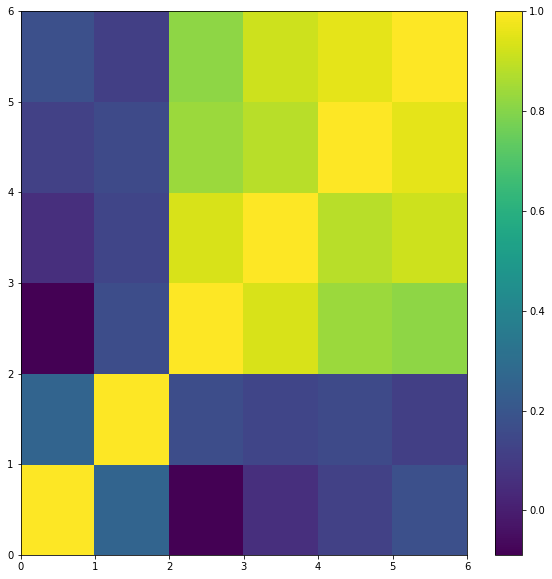

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize= (10, 10))
plt.pcolor(all_n5_scores)
plt.axis('tight')
plt.colorbar()